# Visible

In [1]:
##################################################
#
# Libraries
#


from metpy.plots    import colortables
from metpy.plots    import add_timestamp
from datetime       import datetime
from siphon.catalog import TDSCatalog
from datetime       import datetime

import numpy             as np
import os                as os
import pandas            as pd
import pathlib           as pathlib

import metpy
import cartopy.crs       as ccrs
import cartopy.feature   as cfeature
import matplotlib.pyplot as plt


#
##################################################

In [2]:
##################################################
#
# Control Setup
#

# %load solutions/data_url.py

total_frames = 45*2

png_processing_directory = "./temp_files_sat_vis/"

gif_file_name = "./graphics_files/RealTime_SAT_VIS_Loop.gif"

image_header_label = "GOES 16 Band 2 [0.64 µm Visble Red]"

# Cell content replaced by load magic replacement.

# Create variables for URL generation

image_date = datetime.utcnow().date()
region = 'CONUS'
channel = 2

# We want to match something like:
# https://thredds-test.unidata.ucar.edu/thredds/catalog/satellite/goes16/GOES16/Mesoscale-1/Channel08/20181113/catalog.html

# Construct the data_url string

data_url = ('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/'
            f'CloudAndMoistureImagery/{region}/Channel{channel:02d}/current/catalog.xml')

# Print out your URL and verify it works!

print(data_url)

#
##################################################

https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/CloudAndMoistureImagery/CONUS/Channel02/current/catalog.xml


In [3]:
##################################################
#
# Pull Catalog
#

cat = TDSCatalog(data_url)

#
##################################################

In [4]:
##################################################
#
# Create File Inventories
#

file_names_to_retain = list()
file_names_to_use    = list()


for i in range(1,len(cat.datasets[0:total_frames])+1,1) : 
    filename = png_processing_directory + cat.datasets[i].name.replace(".nc",".png")
    file_names_to_retain.append(filename)
    file_names_to_use.append(filename)

        
files_on_hand = [png_processing_directory + s for s in os.listdir(png_processing_directory)]

file_names_to_retain.sort()
file_names_to_use.sort()

#
##################################################    

In [5]:
##################################################
#
# Clean PNG Directory
#

for filename in files_on_hand:
    print(filename)
    if filename not in file_names_to_retain:
        print("Purging ", filename )
        os.remove( filename  )
    else:
        print("Keeping ", filename )

#
##################################################    

./temp_files_sat_vis/Sat_VIS_Loop_Image_2022-01-30_0436.png
Purging  ./temp_files_sat_vis/Sat_VIS_Loop_Image_2022-01-30_0436.png
./temp_files_sat_vis/Sat_VIS_Loop_Image_2022-01-30_0426.png
Purging  ./temp_files_sat_vis/Sat_VIS_Loop_Image_2022-01-30_0426.png
./temp_files_sat_vis/Sat_VIS_Loop_Image_2022-01-30_0456.png
Purging  ./temp_files_sat_vis/Sat_VIS_Loop_Image_2022-01-30_0456.png
./temp_files_sat_vis/Sat_VIS_Loop_Image_2022-01-30_0446.png
Purging  ./temp_files_sat_vis/Sat_VIS_Loop_Image_2022-01-30_0446.png
./temp_files_sat_vis/Sat_VIS_Loop_Image_2022-01-30_0506.png
Purging  ./temp_files_sat_vis/Sat_VIS_Loop_Image_2022-01-30_0506.png
./temp_files_sat_vis/Sat_VIS_Loop_Image_2022-01-29_2141.png
Purging  ./temp_files_sat_vis/Sat_VIS_Loop_Image_2022-01-29_2141.png


2022-01-30 21:01:17 UTC 2022-01-30 14:01:17 MST
2022-01-30 20:51:17 UTC 2022-01-30 13:51:17 MST
2022-01-30 20:41:17 UTC 2022-01-30 13:41:17 MST
2022-01-30 20:31:17 UTC 2022-01-30 13:31:17 MST
2022-01-30 20:21:17 UTC 2022-01-30 13:21:17 MST
2022-01-30 20:11:17 UTC 2022-01-30 13:11:17 MST
2022-01-30 20:01:17 UTC 2022-01-30 13:01:17 MST
2022-01-30 19:51:17 UTC 2022-01-30 12:51:17 MST
2022-01-30 19:41:17 UTC 2022-01-30 12:41:17 MST
2022-01-30 19:31:17 UTC 2022-01-30 12:31:17 MST
2022-01-30 19:21:17 UTC 2022-01-30 12:21:17 MST
2022-01-30 19:11:17 UTC 2022-01-30 12:11:17 MST
2022-01-30 19:01:17 UTC 2022-01-30 12:01:17 MST
2022-01-30 18:51:17 UTC 2022-01-30 11:51:17 MST
2022-01-30 18:41:17 UTC 2022-01-30 11:41:17 MST
2022-01-30 18:31:17 UTC 2022-01-30 11:31:17 MST
2022-01-30 18:21:17 UTC 2022-01-30 11:21:17 MST
2022-01-30 18:11:17 UTC 2022-01-30 11:11:17 MST
2022-01-30 18:01:17 UTC 2022-01-30 11:01:17 MST
2022-01-30 17:51:17 UTC 2022-01-30 10:51:17 MST
2022-01-30 17:41:17 UTC 2022-01-30 10:41

ChunkedEncodingError: ("Connection broken: InvalidChunkLength(got length b'', 0 bytes read)", InvalidChunkLength(got length b'', 0 bytes read))

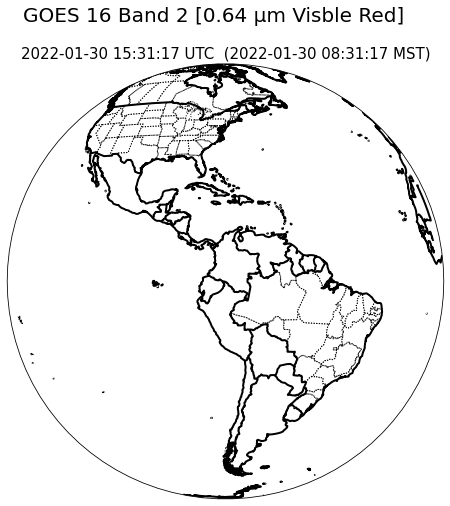

In [6]:
##################################################
#
# Create PNGs
#

for i in range(0,len(cat.datasets[0:total_frames])+1,1) : 

    dataset = cat.datasets[i]
    
    dataset_png_file_name = png_processing_directory + dataset.name.replace(".nc", ".png")
    
    if (not pathlib.Path(dataset_png_file_name).is_file() ):

        ds = dataset.remote_access(use_xarray=True)
        dat = ds.metpy.parse_cf('Sectorized_CMI')
        proj = dat.metpy.cartopy_crs
        x = dat['x']
        y = dat['y']


        tz='America/Denver'
        time_utc   = datetime.strptime(ds.start_date_time, '%Y%j%H%M%S')
        valid_time = pd.to_datetime(time_utc).tz_localize(tz="UTC").strftime("%Y-%m-%d %H:%M:%S %Z")
        local_time = pd.to_datetime(time_utc).tz_localize(tz="UTC").tz_convert(tz=tz).strftime("%Y-%m-%d %H:%M:%S %Z")

        file_time = pd.to_datetime(time_utc).tz_localize(tz="UTC").strftime("%Y-%m-%d_%H%M")


        print(valid_time,local_time)



        fig = plt.figure(figsize=(13, 8), facecolor = 'white')

        plt.suptitle(image_header_label,
                     fontsize = 20, 
                     color    = "black")
        ax = fig.add_subplot(1, 1, 1, projection=proj)
        ax.set_title(valid_time + "  (" + local_time+")",
                        fontsize=15, color="black")
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=2)
        ax.add_feature(cfeature.STATES.with_scale('50m'),    linestyle=':', edgecolor='black')
        ax.add_feature(cfeature.BORDERS.with_scale('50m'),   linewidth=2, edgecolor='black')

    

        im = ax.imshow(np.sqrt(dat), extent=(x.min(), x.max(), y.min(), y.max()), origin='upper',cmap='Greys_r')

        #wv_cmap = colortables.get_colortable('WVCIMSS_r')
        #im.set_cmap(wv_cmap)
        plt.tight_layout()

        plt.savefig( dataset_png_file_name)
        plt.close()
    else:
        print("We already have this one!")
    

#
##################################################

In [ ]:
##################################################
#
# Convert PNGs into an Animated GIF
#

big_string = " ".join(file_names_to_use)

os.system("convert -delay 15 " + 
          big_string + 
          " " + 
          gif_file_name)

#
##################################################